# GPT-2 Joke Generator

---

Fine-tuned the HuggingFace GPT2 medium model to generate short-jokes


Note: Some Jokes generated are **`NSFW`**

# Setup

In [ ]:
!pip install transformers

     |████████████████████████████████| 2.1MB 5.6MB/s 
     |████████████████████████████████| 3.3MB 38.4MB/s 
     |████████████████████████████████| 901kB 40.4MB/s 


In [ ]:
import os
import time
import datetime
from google.colab import drive

import pandas as pd
import seaborn as sns
import numpy as np
import random

import matplotlib.pyplot as plt
% matplotlib inline

import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)

from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2Config, GPT2LMHeadModel
from transformers import AdamW, get_linear_schedule_with_warmup

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
!nvidia-smi

Thu Apr 29 15:34:48 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8    25W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#Loading the Dataset

In [ ]:
# mount my Google Drive directory and access the training data located there
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

# Load the dataset into a pandas dataframe.
df = pd.read_csv("/content/drive/MyDrive/BE_PROJECT/train.tsv", delimiter=',', header=None, names=['id', 'label', 'alpha', 'sentence'])

# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(df.shape[0]))

# Display 10 random rows from the data.
df.sample(10)

Number of training sentences: 347,486



,id,label,alpha,sentence
199850,199850,1,a,why did the superhero flush the toilet it was ...
202996,202996,0,a,yet some have warned of a mighty wave of mosqu...
165767,165767,0,a,it is expected that most of the line open will...
28527,28527,0,a,people will notice he said.
336081,336081,1,a,q - why are bachelors thin and married men fat...
154154,154154,1,a,i saw the strangest thing ever today. i threw ...
247687,247687,0,a,connell was fired for electoral phone-scriptin...
140139,140139,0,a,her planned return comes at an edgy time for p...
232251,232251,0,a,but he added the nhs provides -hour care and t...
64545,64545,1,a,when im done shitting on your car im going to ...


In [ ]:
# load into a data frame
df1 = df[df['label']==1]

In [ ]:
df1

,id,label,alpha,sentence
1,1,1,a,im scared of trampolines they make me jump.
5,5,1,a,i will base my art on something deeply persona...
6,6,1,a,what do orphans get at christmas lonely.
8,8,1,a,when in doubt ask yourself wwbd what would bey...
9,9,1,a,what is the difference between a racist joke a...
...,...,...,...,...
347476,347476,1,a,what is the boogeyman is part-time job boogeynan.
347477,347477,1,a,what did the apple say to the banana nothing -...
347479,347479,1,a,what do you call a poor pepper farmer a jalape...
347480,347480,1,a,i love pressing f it is so refreshing.


In [ ]:
df1 = df1.sentence

In [ ]:
df1.drop_duplicates

<bound method Series.drop_duplicates of 1               im scared of trampolines they make me jump.
5         i will base my art on something deeply persona...
6                  what do orphans get at christmas lonely.
8         when in doubt ask yourself wwbd what would bey...
9         what is the difference between a racist joke a...
                                ...                        
347476    what is the boogeyman is part-time job boogeynan.
347477    what did the apple say to the banana nothing -...
347479    what do you call a poor pepper farmer a jalape...
347480               i love pressing f it is so refreshing.
347484    the neighbor is wife is gonna be so happy when...
Name: sentence, Length: 173635, dtype: object>

# GPT2 Tokenizer

Although the defaults take care of this,I thought I'd show that you can specify some of the special tokens.

In [ ]:
# Load the GPT tokenizer.
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>') #gpt2-medium

Special tokens have been added in the vocabulary, make sure the associated word embedding are fine-tuned or trained.


In [ ]:
print("The max model length is {} for this model, although the actual embedding size for GPT small is 768".format(tokenizer.model_max_length))
print("The beginning of sequence token {} token has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.bos_token_id), tokenizer.bos_token_id))
print("The end of sequence token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.eos_token_id), tokenizer.eos_token_id))
print("The padding token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.pad_token_id), tokenizer.pad_token_id))

The max model length is 1024 for this model, although the actual embedding size for GPT small is 768
The beginning of sequence token <|startoftext|> token has the id 50257
The end of sequence token <|endoftext|> has the id 50256
The padding token <|pad|> has the id 50258


# PyTorch Datasets & Dataloaders


In [ ]:
class GPT2Dataset(Dataset):

  def __init__(self, txt_list, tokenizer, gpt2_type="gpt2", max_length=768):

    self.tokenizer = tokenizer
    self.input_ids = []

    for txt in txt_list:

      encodings_dict = tokenizer('<|startoftext|>'+ txt + '<|endoftext|>', truncation=True, max_length=max_length, padding=False)

      self.input_ids.append(encodings_dict['input_ids'])
  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx]

In [ ]:
dataset = GPT2Dataset(df1, tokenizer)
dataset

In [ ]:
train_samples = sorted(dataset,key=lambda x: len(x))

In [ ]:
sorted_lengths = [len(s) for s in train_samples]

Text(0.5, 1.0, 'Samples after Sorting')

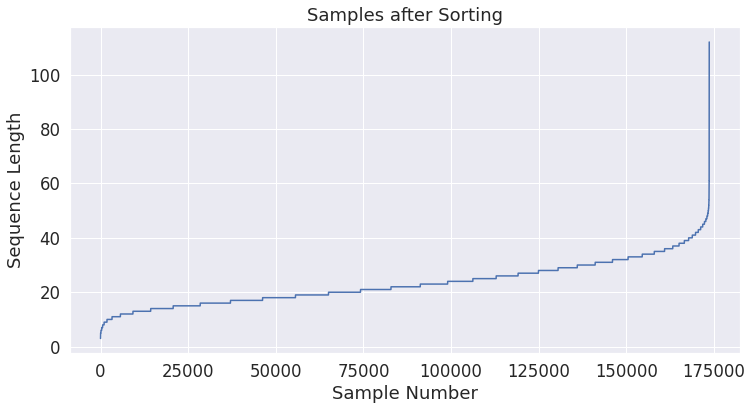

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(range(0, len(sorted_lengths)), sorted_lengths)

plt.xlabel('Sample Number')
plt.ylabel('Sequence Length')
plt.title('Samples after Sorting')


#Sorting the Dataset as per the length of the tokens to optimise training time

In [ ]:
import random
import torch
import numpy as np
from sklearn.model_selection import train_test_split

In [ ]:
batch_size = 32
batch_ordered_sentences = []

print('Creating training batches of size {:}'.format(batch_size))
# Loop over all of the input samples...
while len(train_samples) > 0:

    # Report progress.
  if ((len(batch_ordered_sentences) % 500) == 0):
    print('  Selected {:,} batches.'.format(len(batch_ordered_sentences)))

    # `to_take` is our actual batch size. It will be `batch_size` until
    # we get to the last batch, which may be smaller.
  to_take = min(batch_size, len(train_samples))

    # Pick a random index in the list of remaining samples to start
    # our batch at.
  select = random.randint(0, len(train_samples) - to_take)

    # Select a contiguous batch of samples starting at `select`.
  batch = train_samples[select:(select + to_take)]

    # Each sample is a tuple--split them apart to create a separate list of
    # sequences and a list of labels for this batch.
  batch_ordered_sentences.append([s for s in batch])
    # Remove these samples from the list.
  del train_samples[select:select + to_take]

print('\n  DONE - {:,} batches.'.format(len(batch_ordered_sentences)))

Creating training batches of size 32
  Selected 0 batches.
  Selected 500 batches.
  Selected 1,000 batches.
  Selected 1,500 batches.
  Selected 2,000 batches.
  Selected 2,500 batches.
  Selected 3,000 batches.
  Selected 3,500 batches.
  Selected 4,000 batches.
  Selected 4,500 batches.
  Selected 5,000 batches.

  DONE - 5,427 batches.


In [ ]:
print(batch_ordered_sentences[0])

[[50257, 260, 325, 283, 3533, 1043, 503, 986, 2644, 706, 2130, 3443, 4721, 262, 3420, 13, 50256], [50257, 4919, 750, 262, 1310, 12967, 1592, 379, 22036, 339, 3170, 18505, 319, 18128, 1295, 13, 50256], [50257, 10919, 318, 11398, 290, 34866, 992, 290, 28087, 503, 534, 3318, 444, 534, 49890, 13, 50256], [50257, 8807, 264, 3988, 481, 651, 428, 1312, 910, 23112, 355, 1312, 18342, 3371, 616, 45885, 50256], [50257, 22850, 389, 612, 645, 12711, 82, 319, 474, 21251, 780, 340, 318, 257, 3623, 5440, 50256], [50257, 10919, 466, 345, 869, 257, 7365, 805, 326, 5667, 4928, 1903, 257, 33826, 666, 12274, 50256], [50257, 10919, 466, 345, 869, 2130, 508, 20605, 591, 329, 1200, 18384, 257, 2747, 67, 2676, 50256], [50257, 647, 23151, 82, 508, 1239, 651, 6405, 4191, 29915, 257, 7684, 286, 3797, 11084, 13, 50256], [50257, 20657, 257, 1302, 1028, 9963, 13825, 416, 20023, 1310, 3735, 3988, 866, 262, 4675, 13, 50256], [50257, 22850, 264, 620, 259, 4327, 12171, 283, 1239, 15488, 780, 339, 468, 3236, 3296, 13, 50

In [ ]:
py_inputs = []
py_attn_masks = []

  # For each batch...
for batch_inputs in batch_ordered_sentences:

    # New version of the batch, this time with padded sequences and now with
    # attention masks defined.
  batch_padded_inputs = []
  batch_attn_masks = []

    # First, find the longest sample in the batch.
    # Note that the sequences do currently include the special tokens!
  max_size = max([len(sen) for sen in batch_inputs])

    #print('Max size:', max_size)

    # For each input in this batch...
  for sen in batch_inputs:

        # How many pad tokens do we need to add?
      num_pads = max_size - len(sen)

        # Add `num_pads` padding tokens to the end of the sequence.
      padded_input = sen + [tokenizer.pad_token_id]*num_pads

        # Define the attention mask--it's just a `1` for every real token
        # and a `0` for every padding token.
      attn_mask = [1] * len(sen) + [0] * num_pads

        # Add the padded results to the batch.
      batch_padded_inputs.append(padded_input)
      batch_attn_masks.append(attn_mask)

    # Our batch has been padded, so we need to save this updated batch.
    # We also need the inputs to be PyTorch tensors, so we'll do that here.
  py_inputs.append(torch.tensor(batch_padded_inputs))
  py_attn_masks.append(torch.tensor(batch_attn_masks))
  # Get the new list of lengths after sorting.
padded_lengths = []

  # For each batch...
for batch in py_inputs:
    # For each sample...
  for s in batch:
      # Record its length.
      padded_lengths.append(len(s))

  # Sum up the lengths to the get the total number of tokens after smart batching.
smart_token_count = np.sum(padded_lengths)

  # To get the total number of tokens in the dataset using fixed padding, it's
  # as simple as the number of samples times our `max_len` parameter (that we
  # would pad everything to).
fixed_token_count = len(df1) * 64

  # Calculate the percentage reduction.
prcnt_reduced = (fixed_token_count - smart_token_count) / float(fixed_token_count)

print('Total tokens:')
print('   Fixed Padding: {:,}'.format(fixed_token_count))
print('  Smart Batching: {:,}  ({:.1%} less)'.format(smart_token_count, prcnt_reduced))

Total tokens:
   Fixed Padding: 11,112,640
  Smart Batching: 4,035,129  (63.7% less)


In [ ]:
py_inputs_train, py_inputs_test, py_attn_masks_train, py_attn_masks_test= train_test_split(py_inputs, py_attn_masks, test_size=0.3, random_state=42)

In [ ]:
print(len(py_inputs_train))

3798


# Finetune GPT2 Language Model

In [ ]:
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False,)

# instantiate the model
model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)

# this step is necessary because I've added some tokens (bos_token, etc) to the embeddings
# otherwise the tokenizer and model tensors won't match up
model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU.
device = torch.device("cuda")
model.cuda()

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

Increasing Dropout:

In [ ]:
model.config.attn_pdrop = 0.2

In [ ]:
model.config.resid_pdrop = 0.2

In [ ]:
model.config.embd_pdrop = 0.2

In [ ]:
# some parameters I cooked up that work reasonably well

epochs = 4
learning_rate = 5e-4
warmup_steps = 1e2
epsilon = 1e-8

# this produces sample output every 100 steps
sample_every = 100

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch)
optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )

In [ ]:
# Total number of training steps is [number of batches] x [number of epochs].
# (Note that this is not the same as the number of training samples).
total_steps = len(py_inputs_train) * epochs

# Create the learning rate scheduler.
# This changes the learning rate as the training loop progresses
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = warmup_steps,
                                            num_training_steps = total_steps)

In [ ]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

In [ ]:
total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step in range(0, len(py_inputs_train)):

        b_input_ids = py_inputs_train[step].to(device)
        b_labels = py_inputs_train[step].to(device)
        b_masks = py_attn_masks_train[step].to(device)

        model.zero_grad()

        outputs = model(  b_input_ids,
                          labels=b_labels,
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(py_inputs_train), batch_loss, elapsed))

            model.eval()

            sample_outputs = model.generate(
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,
                                    top_k=50,
                                    max_length = 200,
                                    top_p=0.95,
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(py_inputs_train)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for stepz in range(0, len(py_inputs_test)):

        b_input_ids = py_inputs_test[stepz].to(device)
        b_labels = py_inputs_test[stepz].to(device)
        b_masks = py_attn_masks_test[stepz].to(device)


        with torch.no_grad():

            outputs  = model(b_input_ids,
#                            token_type_ids=None,
                             attention_mask = b_masks,
                            labels=b_labels)

            loss = outputs[0]

        batch_loss = loss.item()
        total_eval_loss += batch_loss

    avg_val_loss = total_eval_loss / len(py_inputs_test)

    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  3,798. Loss: 4.510076999664307.   Elapsed: 0:00:44.
0:  bipartisans is the best way to describe it


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  3,798. Loss: 4.135258674621582.   Elapsed: 0:01:28.
0:  increasingi was the boss of the car for me. now i do not work  times a month or more.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  3,798. Loss: 4.257789134979248.   Elapsed: 0:02:10.
0: daywhat do you call a horse with a great life in his back pocket a horse that has been stolen.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  3,798. Loss: 4.51275110244751.   Elapsed: 0:02:56.
0:  Hangmy friend is so ugly that he just lost his chin in an airplane he has to be a virgin.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  3,798. Loss: 4.030410289764404.   Elapsed: 0:03:38.
0:  foodsi wish i had an ax to pick up some of my tweets about my workday today


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  3,798. Loss: 4.129608631134033.   Elapsed: 0:04:22.
0:  trailwhat do you call an epileptic cow a cow with diarrhea.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  3,798. Loss: 4.1397013664245605.   Elapsed: 0:05:04.
0: intendi like my coffee like i like my women. sweet sweet. i like my coffee like i like my women. im pretty sure there is a difference but i just can not get mad at you.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  3,798. Loss: 3.5489890575408936.   Elapsed: 0:05:48.
0:  surroundit is a great way to show you have the same level of confidence and joy that you would haveyou would have if you had a kid with a heart.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  3,798. Loss: 3.919619083404541.   Elapsed: 0:06:32.
0:  reflexwhat do you call someone who says stupid things noob


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  3,798. Loss: 3.855703115463257.   Elapsed: 0:07:15.
0:  displaywhat is a blonde is favorite fruit a apple.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  3,798. Loss: 4.064340114593506.   Elapsed: 0:08:00.
0:  pastorif you love my new xmas turkey you will probably like it too.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  3,798. Loss: 3.434209108352661.   Elapsed: 0:08:46.
0:  illicitwhat do you say when you find a muslim in your driveway nothing they say i swear i know what you are doing.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  3,798. Loss: 3.7014191150665283.   Elapsed: 0:09:28.
0:  Liberationa jew is favourite game is called the black hole because its not quite as much fun as the first.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  3,798. Loss: 3.5943384170532227.   Elapsed: 0:10:12.
0:  Namhow many hipsters does it take to screw in a lightbulb.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  3,798. Loss: 3.724595069885254.   Elapsed: 0:10:55.
0: IONim going to give a book on why women get breast implants. it will be called the man who said he made women look better than they do.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  3,798. Loss: 3.600602149963379.   Elapsed: 0:11:39.
0:  glimpsewhat do you call an elderly jew a condescending jew.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  3,798. Loss: 3.3365819454193115.   Elapsed: 0:12:25.
0:  Laurei told my husband to be like his mother. he said fuck you what do you want me to do. she said you just told her he is an idiot when it comes to choosing his children.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  3,798. Loss: 3.6538054943084717.   Elapsed: 0:13:09.
0: ismwhat is a muslim is favorite car one...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  3,798. Loss: 3.685624599456787.   Elapsed: 0:13:53.
0: ouni have a lot of self-depreciating secrets i keep hiding from people.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  3,798. Loss: 3.5410852432250977.   Elapsed: 0:14:38.
0:  electionwhat does it take to change a light bulb when the bulb just flushes out of place and it has to go fuck herself edit formatting this one is hard...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  3,798. Loss: 3.5739145278930664.   Elapsed: 0:15:22.
0:  crazywhat is the difference between a cat and a hooker a hooker has no teeth.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  3,798. Loss: 3.3690521717071533.   Elapsed: 0:16:07.
0:  benchwhat did the blind man say when the bird flew in on him awwwww


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  3,798. Loss: 3.6045360565185547.   Elapsed: 0:16:50.
0:  incorporatedwhat did the british baby seal say at his wedding i will be leaving a  link


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  3,798. Loss: 3.778388738632202.   Elapsed: 0:17:34.
0: Peterwhat is the difference between a dildo and a baby i do not use one of them.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  3,798. Loss: 3.8171424865722656.   Elapsed: 0:18:18.
0: uringi found a new material today but i do not like having to deal with it. i just put it in my own pocket. -me to chemistry professor on the radio


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  3,798. Loss: 3.774043083190918.   Elapsed: 0:19:03.
0:  reproductivei just had to admit i was not feeling well but this is something a person can learn to do with a stick of gum.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  3,798. Loss: 3.7480320930480957.   Elapsed: 0:19:47.
0:  zonemy mom says she is worried about the future. i tell her that is not how i like myself.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  3,798. Loss: 3.465579032897949.   Elapsed: 0:20:33.
0:  commitswhat did the cannibal say when he dumped his girlfriend i can not be pregnant.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  3,798. Loss: 3.4611976146698.   Elapsed: 0:21:17.
0:  ironyis there a sense in which someone can be anything except a woman


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  3,798. Loss: 3.5613017082214355.   Elapsed: 0:22:02.
0:  Sahhey your mum your dad. who do you want my dad and your mum.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  3,798. Loss: 3.3733670711517334.   Elapsed: 0:22:45.
0:  Bryanwhy does not helen keller use the bathroom she has a lisp.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  3,798. Loss: 3.6909356117248535.   Elapsed: 0:23:29.
0:  spiritswhat kind of fish can survive the longest a tuna a tuna-a-tuna.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,300  of  3,798. Loss: 3.669292449951172.   Elapsed: 0:24:11.
0:  seeswhy did the chicken cross the road to say hello from the other side.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,400  of  3,798. Loss: 3.774386405944824.   Elapsed: 0:24:57.
0:  hungrywhat is the best part about an abortion in the u.s. abortion.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,500  of  3,798. Loss: 3.3953287601470947.   Elapsed: 0:25:39.
0:  PTmy dad told me my momma was a slut after my father said she did not have the time. i told her a little about my brother.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,600  of  3,798. Loss: 3.6408071517944336.   Elapsed: 0:26:24.
0: üwhat do you call a prostitute with one leg homeless.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,700  of  3,798. Loss: 3.264779567718506.   Elapsed: 0:27:10.
0: rucewhat do you get if you throw a baby in a pool a pool.

  Average training loss: 4.02
  Training epoch took: 0:27:52

Running Validation...
  Validation Loss: 3.55
  Validation took: 0:03:33

======== Epoch 2 / 4 ========
Training...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  3,798. Loss: 3.210814952850342.   Elapsed: 0:00:44.
0:  derivativesi will walk you so hard but you will walk so hard yeah that is the punchline.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  3,798. Loss: 3.387960910797119.   Elapsed: 0:01:29.
0: what does a hipster burn after an acid trip.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  3,798. Loss: 3.7321584224700928.   Elapsed: 0:02:10.
0:  rememberingwhy do not bambals eat their friends they have no friends.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  3,798. Loss: 3.730722188949585.   Elapsed: 0:02:56.
0:  Sourcesthere is no way i can not be in bed so peacefully until after the first minute when the doorbell rings in front of me and you are gone by my car


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  3,798. Loss: 3.2948474884033203.   Elapsed: 0:03:39.
0: emsif you can not tell me anything you cannot tell me... you did not try.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  3,798. Loss: 3.533008575439453.   Elapsed: 0:04:22.
0: tzsometimes im just trying to get a better taste of your food when im in a coma.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  3,798. Loss: 3.8559460639953613.   Elapsed: 0:05:05.
0: matici like to think im in a relationship with a  year old black woman it feels like she is an old friend to me


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  3,798. Loss: 3.0415375232696533.   Elapsed: 0:05:49.
0:  syndtwo silkworms met... two silkworms met


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  3,798. Loss: 3.2975289821624756.   Elapsed: 0:06:32.
0:  gamwhat is the difference between snowmen and snowwomen snowballs.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  3,798. Loss: 3.4473001956939697.   Elapsed: 0:07:15.
0:  injurywhat did the hippie pedophile ask his mother do you know how i feel about that thing


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  3,798. Loss: 3.786630630493164.   Elapsed: 0:08:00.
0: azawhat was the name of the pokemon that turned itself into a cat person


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  3,798. Loss: 3.028902769088745.   Elapsed: 0:08:46.
0:  membranei tried to join a support group the other day... link i mist


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  3,798. Loss: 3.101879119873047.   Elapsed: 0:09:28.
0: ijingwhat do you call it when you drop down a toilet paper roll a roll.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  3,798. Loss: 2.9501326084136963.   Elapsed: 0:10:11.
0:  castwhen i told my friend that he was gay he said damn i think i was gay


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  3,798. Loss: 3.1581242084503174.   Elapsed: 0:10:54.
0:  purchwhat do you call a woman that is not wearing a suit anymore and never knows whether to wear it or not.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  3,798. Loss: 3.1378746032714844.   Elapsed: 0:11:39.
0:  shoulderswhat do you call a black woman who drives a black airplane a pilot you racist.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  3,798. Loss: 2.936230182647705.   Elapsed: 0:12:25.
0:  builthey guys i know what a lot of you do not understand. you have not had a meal for  hours today.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  3,798. Loss: 3.1144566535949707.   Elapsed: 0:13:09.
0:  openlywhy do not blind people ever get married because the dog will not come when it is too darn bright.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  3,798. Loss: 3.343308210372925.   Elapsed: 0:13:52.
0:  haltedit is just so sad to be in a nudist colony... it is not too many of their people are invited.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  3,798. Loss: 3.0531210899353027.   Elapsed: 0:14:37.
0:  Nikknock knock who is there. carlos. carlos who  carlos pasta..


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  3,798. Loss: 3.0774037837982178.   Elapsed: 0:15:21.
0:  tinwhat does bill clinton and a jew have in common they both say you will never get it


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  3,798. Loss: 2.694786548614502.   Elapsed: 0:16:06.
0:  clinicalwhy do not cannibals have children cause it kills their parents.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  3,798. Loss: 3.183289051055908.   Elapsed: 0:16:49.
0: lectionsjason williams... link his brother died while he was playing the triangle. he just could not find the right partner. jason williams is always wrong. jason williams has two feelings. he can not be right with his feelings.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  3,798. Loss: 3.0818350315093994.   Elapsed: 0:17:34.
0: elswhat do you call a muslim that eats a lot of pork a muslim.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  3,798. Loss: 3.3815956115722656.   Elapsed: 0:18:17.
0: labwhy do not pirates use the word pirate because nobody likes it edit spelling.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  3,798. Loss: 3.3536527156829834.   Elapsed: 0:19:02.
0:  triplei like my jokes like i like my men... cold-opening and without any punch.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  3,798. Loss: 3.5082080364227295.   Elapsed: 0:19:46.
0: 220[first date] me im like a baby.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  3,798. Loss: 3.005556583404541.   Elapsed: 0:20:33.
0:  Seeme to a beautiful girl with  nipples. how come i can only make  million dollars a year


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  3,798. Loss: 2.9955973625183105.   Elapsed: 0:21:17.
0: @@if i ever have a boyfriend i like to make a chemistry joke that i use chemistry metaphors.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  3,798. Loss: 3.0121254920959473.   Elapsed: 0:22:01.
0:  hostdid you hear about the man who had an oral sex operation he was having it a tongue.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  3,798. Loss: 2.9574670791625977.   Elapsed: 0:22:44.
0: rolewhat is an elephant is favorite sport  the leap.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  3,798. Loss: 3.079737901687622.   Elapsed: 0:23:28.
0: iacdid you know that ronald mcdonald is has cancer he is the only one living mcdonald


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,300  of  3,798. Loss: 3.3698678016662598.   Elapsed: 0:24:11.
0:  LDhow does nasa plan a party they planet


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,400  of  3,798. Loss: 3.5030345916748047.   Elapsed: 0:24:57.
0:  Listenyou know what makes me smile facial muscles.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,500  of  3,798. Loss: 2.7667219638824463.   Elapsed: 0:25:39.
0:  dyknock knock who is there. brian. brian who  brian old and alive. -


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,600  of  3,798. Loss: 3.175825357437134.   Elapsed: 0:26:24.
0:  Domesticwhy did not the cannibal go to rehab he only ate vegetables.


RuntimeError: ignored

Summary of the training process.

In [ ]:
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

In [ ]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [ ]:
sample_outputs = model.generate(
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,
                                    top_k=50,
                                    max_length = 200,
                                    top_p=0.99,
                                    num_return_sequences=1,
                                    num_beams = 1
                                )

In [ ]:
print(tokenizer.decode(sample_outputs[0], skip_special_tokens=True))

# Saving & Loading Fine-Tuned Model


In [ ]:
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))


Saving model to ./model_save/


('./model_save/tokenizer_config.json',
 './model_save/special_tokens_map.json',
 './model_save/vocab.json',
 './model_save/merges.txt',
 './model_save/added_tokens.json')

In [ ]:
!cp -r /content/model_save "/content/drive/MyDrive"

In [ ]:
!ls -l --block-size=M ./model_save/pytorch_model.bin

-rw-r--r-- 1 root root 487M Mar  2 19:15 ./model_save/pytorch_model.bin


In [ ]:
# Copy the model files to a directory in your Google Drive.
!cp -r ./model_save/ $data_dir

# # Load a trained model and vocabulary that you have fine-tuned
#model = GPT2LMHeadModel.from_pretrained(output_dir)
#tokenizer = GPT2Tokenizer.from_pretrained(output_dir)
#model.to(device)

cp: missing destination file operand after './model_save/'
Try 'cp --help' for more information.


# Generate Text

In [ ]:
model.eval()

prompt = "<|startoftext|>"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

print(generated)

sample_outputs = model.generate(
                                generated,
                                #bos_token_id=random.randint(1,30000),
                                do_sample=True,
                                top_k=50,
                                max_length = 300,
                                top_p=0.95,
                                num_return_sequences=3
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


tensor([[50257]], device='cuda:0')
0: the first rule of fight club is do not talk to each other. i heard it was a really well arranged event.


1: i have  kids  and  i have to go home


2: i used to be addicted to soap... i am clean now




These aren't bad at all!
